<a href="https://colab.research.google.com/github/ParhamRajabalian/Fall-Detection/blob/main/Fall_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mediapipe
!pip install einops
!pip install matplotlib
!pip install opencv-python
!pip install torch torchvision torchaudio

  Using cached mediapipe-0.10.21-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (9.7 kB)
  Using cached protobuf-4.25.7-cp37-abi3-manylinux2014_x86_64.whl.metadata (541 bytes)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached mediapipe-0.10.21-cp311-cp311-manylinux_2_28_x86_64.whl (35.6 MB)
Using cached protobuf-4.25.7-cp37-abi3-manylinux2014_x86_64.whl (294 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
ydf 0.11.0 requires protobuf<6.0.0,>=5.29.1, but you hav

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Fall Video.mp4 to Fall Video (1).mp4


In [ ]:
!pip uninstall -y numpy mediapipe protobuf
!pip install numpy==1.24.3 protobuf==4.25.3 mediapipe==0.10.21

In [1]:
import numpy as np
print(np.__version__)  # باید 1.24.3 باشه

import mediapipe as mp
print("✅ MediaPipe imported successfully!")


1.24.3
✅ MediaPipe imported successfully!


In [2]:
import cv2
import mediapipe as mp
import numpy as np

mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False)

video_path = "Fall Video.mp4"
cap = cv2.VideoCapture(video_path)

all_keypoints = []

while cap.isOpened():
    success, frame = cap.read()
    if not success:
        break

    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose.process(image)

    if results.pose_landmarks:
        keypoints = []
        for lm in results.pose_landmarks.landmark:
            keypoints.append([lm.x, lm.y])
        all_keypoints.append(keypoints)

cap.release()
all_keypoints = np.array(all_keypoints)
print("✅ Total frames with pose:", len(all_keypoints))
print("✅ Shape of keypoints array:", all_keypoints.shape)


✅ Total frames with pose: 1079
✅ Shape of keypoints array: (1079, 33, 2)


In [3]:
def normalize_2d_pose(pose_2d):
    root = pose_2d[0]  # مفصل مرکزی (Base of spine)
    pose = pose_2d - root
    norm = np.linalg.norm(pose)
    return pose / norm if norm != 0 else pose

normalized_poses = np.array([normalize_2d_pose(p) for p in all_keypoints])
print("✅ Normalized poses shape:", normalized_poses.shape)


✅ Normalized poses shape: (1079, 33, 2)


In [4]:
poses_2d_flat = normalized_poses.reshape(len(normalized_poses), -1)  # shape: [1079, 66]
print("2D input to model:", poses_2d_flat.shape)


2D input to model: (1079, 66)


In [5]:
import torch
import torch.nn as nn

class PoseLiftingNet(nn.Module):
    def __init__(self, input_size=66, output_size=99):
        super(PoseLiftingNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.relu1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(1024, 1024)
        self.bn2 = nn.BatchNorm1d(1024)
        self.relu2 = nn.ReLU()
        self.drop2 = nn.Dropout(0.5)

        self.out = nn.Linear(1024, output_size)

    def forward(self, x):
        x = self.drop1(self.relu1(self.bn1(self.fc1(x))))
        x = self.drop2(self.relu2(self.bn2(self.fc2(x))))
        x = self.out(x)
        return x


In [6]:
model = PoseLiftingNet()
sample_input = torch.tensor(poses_2d_flat, dtype=torch.float32)  # [1079, 66]
with torch.no_grad():
    output_3d = model(sample_input)  # [1079, 99]
print("Output shape:", output_3d.shape)

Output shape: torch.Size([1079, 99])


In [7]:
predicted_3d_poses = output_3d.numpy().reshape(-1, 33, 3)
print("✅ Reconstructed 3D pose shape:", predicted_3d_poses.shape)


✅ Reconstructed 3D pose shape: (1079, 33, 3)


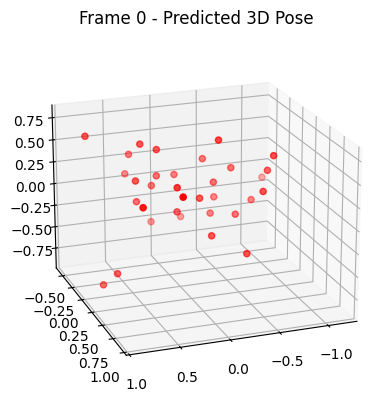

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_pose(pose, title="3D Pose"):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x, y, z = pose[:,0], pose[:,1], pose[:,2]
    ax.scatter(x, y, z, c='r', marker='o')
    ax.set_title(title)
    ax.view_init(elev=20, azim=70)
    plt.show()

# مثال: نمایش فریم اول
plot_3d_pose(predicted_3d_poses[0], title="Frame 0 - Predicted 3D Pose")


In [9]:
poses_3d_gt = np.concatenate([normalized_poses, np.zeros((len(normalized_poses), 33, 1))], axis=2)
poses_3d_gt_flat = poses_3d_gt.reshape(len(poses_3d_gt), -1)  # [1079, 99]
print("Ground truth shape:", poses_3d_gt_flat.shape)


Ground truth shape: (1079, 99)


In [10]:
from torch.utils.data import Dataset, DataLoader

class PoseDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = torch.tensor(inputs, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

dataset = PoseDataset(poses_2d_flat, poses_3d_gt_flat)
loader = DataLoader(dataset, batch_size=32, shuffle=True)


In [11]:
model = PoseLiftingNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()


In [12]:
num_epochs = 30

for epoch in range(num_epochs):
    total_loss = 0.0
    model.train()
    for x_batch, y_batch in loader:
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.6f}")


Epoch 1/30, Loss: 0.185052
Epoch 2/30, Loss: 0.088847
Epoch 3/30, Loss: 0.053547
Epoch 4/30, Loss: 0.034574
Epoch 5/30, Loss: 0.023380
Epoch 6/30, Loss: 0.016300
Epoch 7/30, Loss: 0.011419
Epoch 8/30, Loss: 0.008641
Epoch 9/30, Loss: 0.006841
Epoch 10/30, Loss: 0.005197
Epoch 11/30, Loss: 0.004423
Epoch 12/30, Loss: 0.003703
Epoch 13/30, Loss: 0.003171
Epoch 14/30, Loss: 0.002628
Epoch 15/30, Loss: 0.002269
Epoch 16/30, Loss: 0.002292
Epoch 17/30, Loss: 0.002127
Epoch 18/30, Loss: 0.002426
Epoch 19/30, Loss: 0.001828
Epoch 20/30, Loss: 0.001843
Epoch 21/30, Loss: 0.001857
Epoch 22/30, Loss: 0.001799
Epoch 23/30, Loss: 0.001694
Epoch 24/30, Loss: 0.001788
Epoch 25/30, Loss: 0.002647
Epoch 26/30, Loss: 0.001907
Epoch 27/30, Loss: 0.002151
Epoch 28/30, Loss: 0.002479
Epoch 29/30, Loss: 0.001914
Epoch 30/30, Loss: 0.001608


In [13]:
model.eval()
with torch.no_grad():
    predicted_3d_flat = model(torch.tensor(poses_2d_flat, dtype=torch.float32))
    predicted_3d_poses = predicted_3d_flat.numpy().reshape(-1, 33, 3)

print("✅ Final predicted 3D pose shape:", predicted_3d_poses.shape)


✅ Final predicted 3D pose shape: (1079, 33, 3)


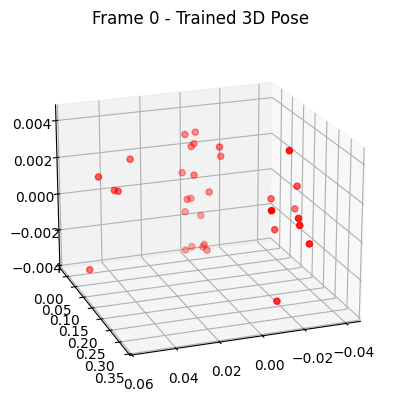

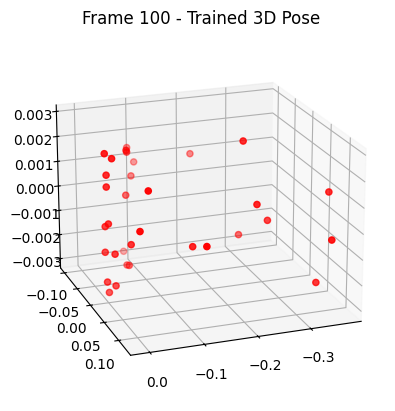

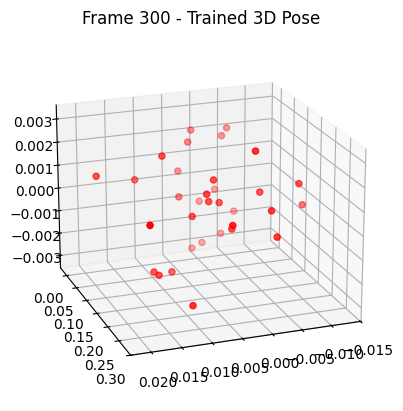

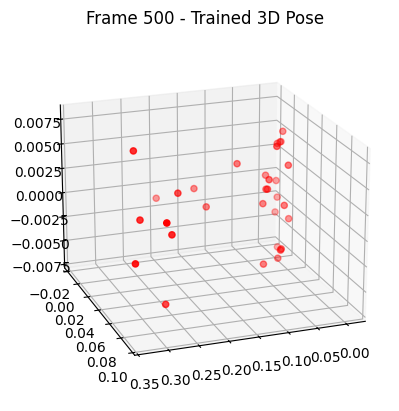

In [14]:
for i in [0, 100, 300, 500]:
    plot_3d_pose(predicted_3d_poses[i], title=f"Frame {i} - Trained 3D Pose")


In [16]:
sequence_length = 300
stride = 10

sequences = []
for start in range(0, len(predicted_3d_poses) - sequence_length + 1, stride):
    seq = predicted_3d_poses[start:start+sequence_length].reshape(sequence_length, -1)
    sequences.append(seq)

sequences = np.array(sequences)  # شکل: [num_seq, 300, 99]
print("✅ Sequences shape:", sequences.shape)


✅ Sequences shape: (78, 300, 99)


In [17]:
labels = np.zeros(len(sequences))
labels[:len(sequences)//2] = 1  # فرضاً نیمی fall

import torch
from torch.utils.data import Dataset, DataLoader

class FallDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

fall_dataset = FallDataset(sequences, labels)
fall_loader = DataLoader(fall_dataset, batch_size=8, shuffle=True)


In [18]:
class FallDetectionNet(nn.Module):
    def __init__(self, input_dim=99, num_classes=2):
        super(FallDetectionNet, self).__init__()

        self.block1 = nn.Sequential(
            nn.Conv1d(input_dim, 128, kernel_size=3, dilation=1, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.block2 = nn.Sequential(
            nn.Conv1d(128, 128, kernel_size=3, dilation=2, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.block3 = nn.Sequential(
            nn.Conv1d(128, 128, kernel_size=3, dilation=4, padding=4),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.block4 = nn.Sequential(
            nn.Conv1d(128, 128, kernel_size=3, dilation=8, padding=8),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # [B, 99, 300]
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.pool(x).squeeze(-1)
        out = self.fc(x)
        return out


In [19]:
model = FallDetectionNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

num_epochs = 10  # برای تست سریع

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for X_batch, y_batch in fall_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = loss_fn(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        predicted = torch.argmax(outputs, dim=1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

    acc = correct / total
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {total_loss:.4f} | Accuracy: {acc:.4f}")


Epoch 1/10 | Loss: 4.4791 | Accuracy: 0.8718
Epoch 2/10 | Loss: 1.8091 | Accuracy: 0.9872
Epoch 3/10 | Loss: 1.1934 | Accuracy: 0.9744
Epoch 4/10 | Loss: 0.7371 | Accuracy: 0.9872
Epoch 5/10 | Loss: 0.8476 | Accuracy: 0.9744
Epoch 6/10 | Loss: 1.1975 | Accuracy: 0.9487
Epoch 7/10 | Loss: 0.7896 | Accuracy: 1.0000
Epoch 8/10 | Loss: 0.8041 | Accuracy: 0.9615
Epoch 9/10 | Loss: 0.6822 | Accuracy: 1.0000
Epoch 10/10 | Loss: 0.5011 | Accuracy: 0.9872


In [20]:
torch.save(model.state_dict(), "lifting_model.pth")
print("✅ Lifting model saved as lifting_model.pth")


✅ Lifting model saved as lifting_model.pth


In [21]:
fall_model = model

In [22]:
torch.save(fall_model.state_dict(), "fall_detection_model.pth")
print("✅ Fall Detection model saved as fall_detection_model.pth")


✅ Fall Detection model saved as fall_detection_model.pth


In [23]:
np.save("predicted_3d_poses.npy", predicted_3d_poses)
print("✅ Predicted 3D poses saved as predicted_3d_poses.npy")


✅ Predicted 3D poses saved as predicted_3d_poses.npy


In [24]:
from google.colab import files
files.download("lifting_model.pth")
files.download("fall_detection_model.pth")
files.download("predicted_3d_poses.npy")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
import cv2
import mediapipe as mp
import numpy as np

mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5)

cap = cv2.VideoCapture("Fall Video.mp4")
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

out = cv2.VideoWriter("Fall_Annotated.mp4", cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

while cap.isOpened():
    success, frame = cap.read()
    if not success:
        break

    image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    result = pose.process(image_rgb)

    if result.pose_landmarks:
        landmarks = result.pose_landmarks.landmark
        coords = np.array([[lm.x * width, lm.y * height] for lm in landmarks])
        x_min, y_min = coords.min(axis=0).astype(int)
        x_max, y_max = coords.max(axis=0).astype(int)

        # رسم کادر اطراف بدن
        cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

        # محاسبه فاصله سر تا پاشنه پا (تقریبی)
        head_y = coords[0, 1]  # nose or head
        foot_y = max(coords[27, 1], coords[28, 1])  # left & right heel
        height_estimate = abs(foot_y - head_y)
        cv2.putText(frame, f"Height(px): {int(height_estimate)}", (x_min, y_min - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    out.write(frame)

cap.release()
out.release()
print("✅ Annotated video saved as Fall_Annotated.mp4")


✅ Annotated video saved as Fall_Annotated.mp4


In [27]:
predicted_3d_poses = np.load("predicted_3d_poses.npy")  # [1079, 33, 3]

cap = cv2.VideoCapture("Fall Video.mp4")
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

out = cv2.VideoWriter("Fall_FinalAnnotated.mp4", cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

frame_id = 0
while cap.isOpened():
    success, frame = cap.read()
    if not success or frame_id >= len(predicted_3d_poses):
        break

    pose = predicted_3d_poses[frame_id]  # [33, 3]

    # محاسبه ارتفاع بدن از z
    head_z = pose[0, 2]  # فرضاً سر
    foot_z = max(pose[27, 2], pose[28, 2])  # پاشنه‌ها
    height_est = abs(foot_z - head_z)

    # شرط ساده برای fall: اگر ارتفاع بدن خیلی کم شده باشه
    is_fall = height_est < 0.3  # عدد بهینه بعداً می‌تونه tune شه

    # رسم برچسب
    label = "FALL" if is_fall else "NO FALL"
    color = (0, 0, 255) if is_fall else (0, 255, 0)
    cv2.putText(frame, label, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.2, color, 3)

    out.write(frame)
    frame_id += 1

cap.release()
out.release()
print("✅ Final annotated video with fall detection saved as Fall_FinalAnnotated.mp4")


✅ Final annotated video with fall detection saved as Fall_FinalAnnotated.mp4


In [31]:
import cv2
import mediapipe as mp
import numpy as np

mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5)

cap = cv2.VideoCapture("Fall Video.mp4")
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

out = cv2.VideoWriter("Fall_State_Tracked.mp4", cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

# وضعیت فعلی بدن: فرض بر اینکه فرد ایستاده شروع می‌کند
current_state = "NO FALL"

# آستانه‌ای برای تشخیص سقوط (با توجه به مقیاس تصویر قابل تغییر است)
fall_threshold = 100  # فاصله سر تا پا کمتر از این یعنی fall
recovery_threshold = 130  # اگر از fall برگشت، وضعیت NO FALL بشه

while cap.isOpened():
    success, frame = cap.read()
    if not success:
        break

    image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    result = pose.process(image_rgb)

    if result.pose_landmarks:
        landmarks = result.pose_landmarks.landmark
        coords = np.array([[lm.x * width, lm.y * height] for lm in landmarks])
        x_min, y_min = coords.min(axis=0).astype(int)
        x_max, y_max = coords.max(axis=0).astype(int)

        # رسم کادر اطراف بدن
        cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

        # محاسبه ارتفاع تقریبی بدن
        head_y = coords[0, 1]
        foot_y = max(coords[27, 1], coords[28, 1])
        height_estimate = abs(foot_y - head_y)

        # منطق استیت‌محور
        if height_estimate < fall_threshold:
            current_state = "FALL"
        elif height_estimate > recovery_threshold:
            current_state = "NO FALL"

        # نمایش مقدار height
        cv2.putText(frame, f"Height(px): {int(height_estimate)}", (x_min, y_min - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

        # نمایش وضعیت
        label_color = (0, 0, 255) if current_state == "FALL" else (0, 255, 0)
        cv2.putText(frame, current_state, (x_min, y_max + 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, label_color, 2)

    out.write(frame)

cap.release()
out.release()
print("✅ Fall_State_Tracked.mp4 with dynamic state-based labels saved.")


✅ Fall_State_Tracked.mp4 with dynamic state-based labels saved.
